In [1]:
#import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *

In [2]:
data_dir = "C:\\Users\\bakel\\Desktop\\GRFMuscleModel\\Old_Young_Walking_Data\\"
# load the data
train_data = np.load(data_dir + 'mixed_train_data.npz')
val_data = np.load(data_dir + 'mixed_val_data.npz')
test_data = np.load(data_dir + 'mixed_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [3]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1153, 100, 3)
y_train shape: (1153, 100, 9)
X_val shape: (142, 100, 3)
y_val shape: (142, 100, 9)
X_test shape: (116, 100, 3)
y_test shape: (116, 100, 9)


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 [Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

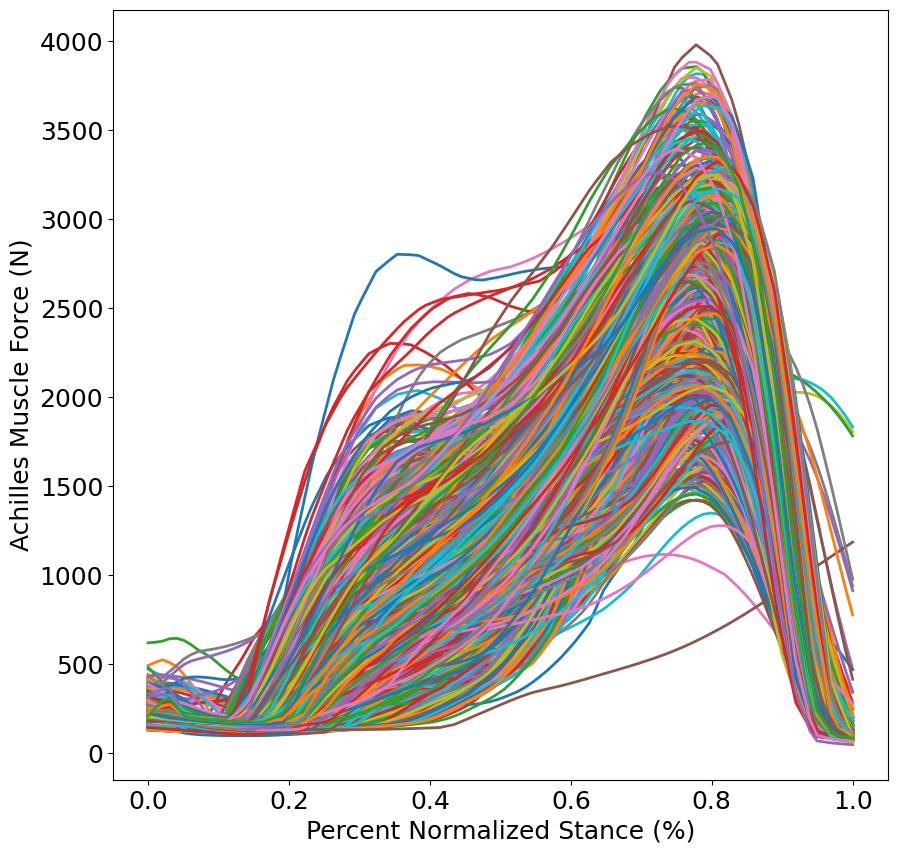

In [4]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance (%)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, output_size, lstm_dropout=0.0, attn_dropout=0.0):
        super(LSTMAttentionModel, self).__init__()
        
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=attn_dropout)
        
        # fully connected layer to map from hidden state to output features
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # pass through LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_length, hidden_size)
        lstm_out = lstm_out.permute(1, 0, 2)  # lstm_out shape: (seq_length, batch, hidden_size)
        
        # Self-attention forward pass
        attention_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attention_out = attention_out.permute(1, 0, 2) # attention_out shape: (batch, seq_length, hidden_size)
        
        # pass through fully connected layer to get the output
        output = self.fc(attention_out) # output shape: (batch, seq_length, output_size)        
        return output

In [6]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# # create dataloaders from datasets
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def train_eval(train_dataset, val_dataset, hidden_size, num_layers, num_heads, lstm_dropout, attn_dropout,
               learning_rate, batch_size, regularization, num_epochs=50): 
    # prepare DataLoader with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # initialize the model
    model = LSTMAttentionModel(input_size=3, hidden_size=hidden_size, num_layers=num_layers, num_heads=num_heads, output_size=9, 
                               lstm_dropout=lstm_dropout, attn_dropout=attn_dropout)
    
    # move the model to the device
    model.to(device)    
    
    # initialize the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
    
    # early stopping setup
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # training loop
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()
        
        # initialize training loss
        train_loss = 0.0

        # iterate over the training data
        for X_batch, y_batch in train_loader:
            # zero the gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(X_batch)
            
            # calculate the loss
            loss = criterion(outputs, y_batch)
            
            # backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # update training loss
            train_loss += loss.item() * X_batch.size(0)
        
        # average training loss over all samples
        train_loss /= len(train_loader.dataset)
        
        # validation step
        # set the model to evaluation mode
        model.eval()
        
        # initialize validation loss
        val_loss = 0.0
        
        # turn off gradients for validation
        with torch.no_grad():
            # iterate over the validation data
            for X_batch, y_batch in val_loader:
                # forward pass
                outputs = model(X_batch)
                
                # calculate the loss
                loss = criterion(outputs, y_batch)
                
                # update validation loss
                val_loss += loss.item() * X_batch.size(0)

        # average validation loss over all samples
        val_loss /= len(val_loader.dataset)
        
        # # print progress
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # early stopping check
        if val_loss < best_val_loss:
            # save best validation loss
            best_val_loss = val_loss
            
            # reset epochs without improvement
            epochs_without_improvement = 0
            
            # save the best model
            # torch.save(model.state_dict(), 'best_model.pth')
            best_model_state_dict = model.state_dict()
        else:
            # increment epochs without improvement
            epochs_without_improvement += 1

        # break if patience limit is reached
        if epochs_without_improvement >= patience:
            break

    # load the best model's state for this set of hyperparameters
    # model.load_state_dict(torch.load('best_model.pth'))
    model.load_state_dict(best_model_state_dict)
    
    # return the best validation loss
    return best_val_loss, model

In [9]:
import optuna

def objective(trial):
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 3, step=1)
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    lstm_dropout = trial.suggest_float('lstm_dropout', 0.0, 0.5, log=False)
    attn_dropout = trial.suggest_float('attn_dropout', 0.0, 0.5, log=False)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)

    # Train and evaluate with these hyperparameters
    val_loss, _ = train_eval(train_dataset, val_dataset, hidden_size, num_layers, num_heads, lstm_dropout, attn_dropout,
                             learning_rate, batch_size, regularization, num_epochs=200)
    
    # Return the validation loss (minimize this value)
    return val_loss

c:\Users\bakel\anaconda3\envs\opensim_scripting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Define the study
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Start the optimization
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2025-11-29 17:28:39,031] A new study created in memory with name: no-name-65d1c138-d328-4141-81ee-2c1170c0cd5e
[I 2025-11-29 17:28:52,244] Trial 0 finished with value: 9511.936578455106 and parameters: {'hidden_size': 32, 'num_layers': 2, 'num_heads': 2, 'lstm_dropout': 0.27797406743544534, 'attn_dropout': 0.15179149566016725, 'learning_rate': 0.0002774662639429906, 'batch_size': 32, 'regularization': 0.005210708050534057}. Best is trial 0 with value: 9511.936578455106.
[I 2025-11-29 17:28:55,817] Trial 1 finished with value: 9440.471720950703 and parameters: {'hidden_size': 64, 'num_layers': 2, 'num_heads': 4, 'lstm_dropout': 0.09689956671584027, 'attn_dropout': 0.28246753250233714, 'learning_rate': 0.0004327103934700769, 'batch_size': 64, 'regularization': 0.0037434970183552758}. Best is trial 1 with value: 9440.471720950703.
[I 2025-11-29 17:29:03,008] Trial 2 finished with value: 70623.62312940141 and parameters: {'hidden_size': 256, 'num_layers': 3, 'num_heads': 2, 'lstm_dropou

In [11]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 2, 'num_heads': 4, 'lstm_dropout': 0.2649797291817925, 'attn_dropout': 0.2152143708632664, 'learning_rate': 0.0015256403293677661, 'batch_size': 32, 'regularization': 0.00020956263626853634}


In [12]:
# Train the final model with the best hyperparameters
final_val_loss, best_model = train_eval(train_dataset, val_dataset,
                                        hidden_size=best_params['hidden_size'],
                                        num_layers=best_params['num_layers'],
                                        num_heads=best_params['num_heads'],
                                        lstm_dropout=best_params['lstm_dropout'],
                                        attn_dropout=best_params['attn_dropout'],
                                        learning_rate=best_params['learning_rate'],
                                        batch_size=best_params['batch_size'],
                                        regularization=best_params['regularization'],
                                        num_epochs=1000)

In [13]:
torch.save(best_model.state_dict(), '..\models\Mixed_lstm-attn.pth')

In [14]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
best_model.eval()

# initialize test loss
test_loss = 0

criterion = nn.MSELoss()

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = best_model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 9227.9658


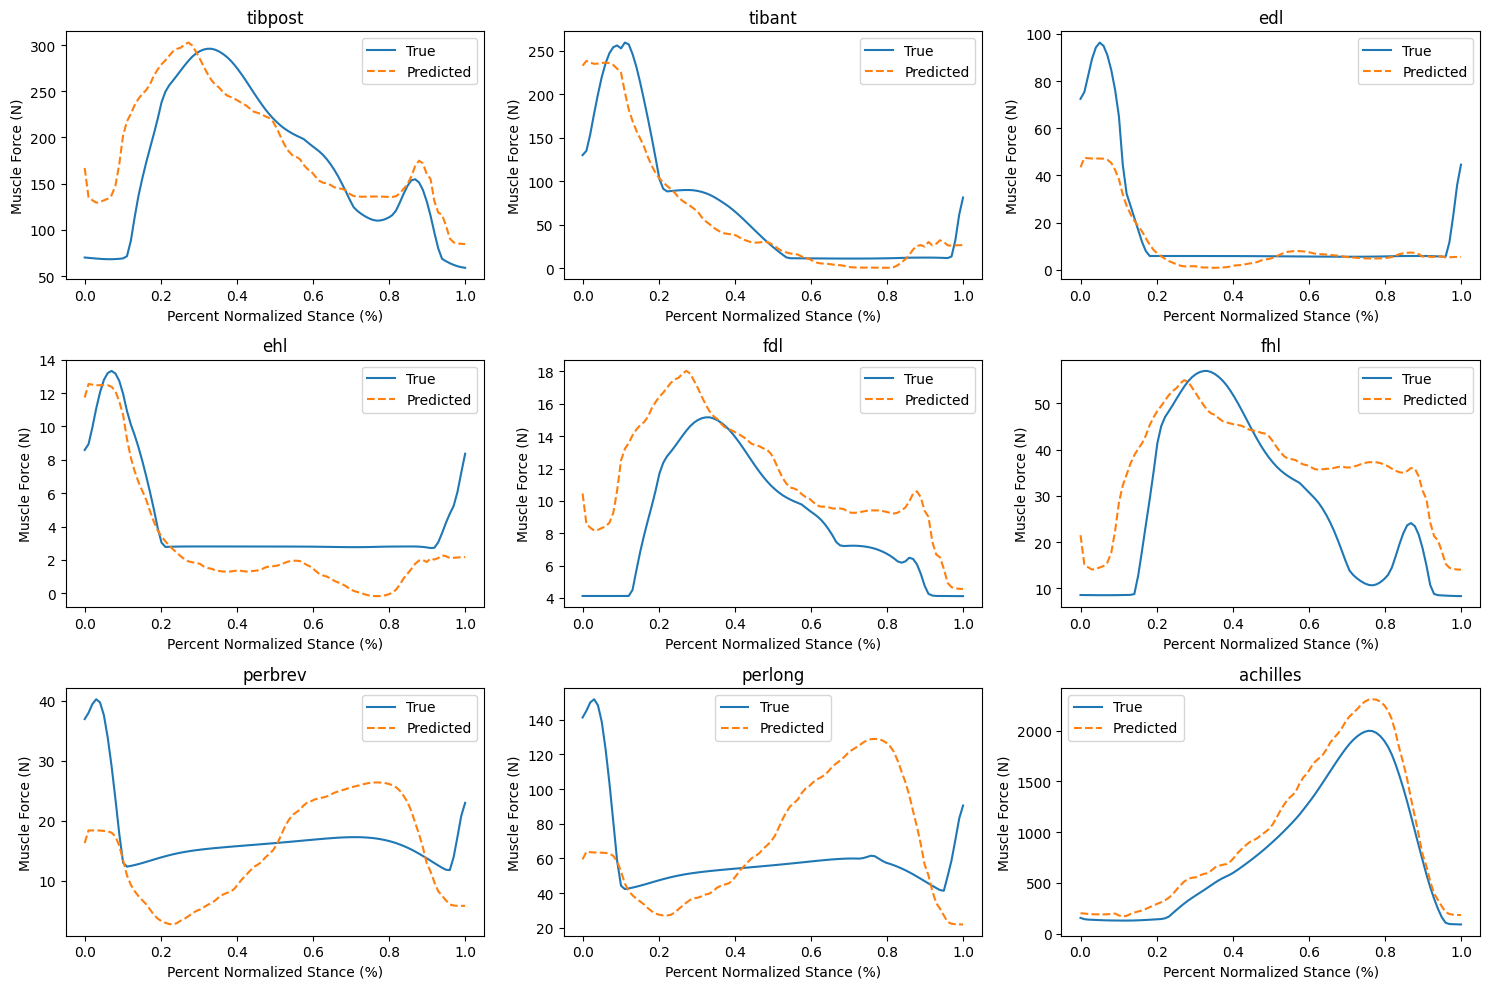

In [15]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()